In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import numpy.random as nr
import math
import scipy.stats as ss
import sklearn.model_selection as ms
from sklearn import preprocessing
from sklearn import linear_model, svm
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
import sklearn.metrics as sklm
from dateutil.relativedelta import relativedelta


In [2]:
works_cleaned = pd.read_csv(r'works.csv')

In [3]:
works_cleaned.head(10)

,Unnamed: 0,CustomerID,Title,FirstName,MiddleName,LastName,Suffix,AddressLine1,AddressLine2,City,...,MaritalStatus,HomeOwnerFlag,NumberCarsOwned,NumberChildrenAtHome,TotalChildren,YearlyIncome,AveMonthSpend,BikeBuyer,Age,dummy
0,0,11000,NaN,Jon,V,Yang,NaN,3761 N. 14th St,NaN,Rockhampton,...,M,1,0,0,2,137947,89,0,55,1.0
1,1,11001,NaN,Eugene,L,Huang,NaN,2243 W St.,NaN,Seaford,...,S,0,1,3,3,101141,117,1,56,1.0
2,2,11002,NaN,Ruben,NaN,Torres,NaN,5844 Linden Land,NaN,Hobart,...,M,1,1,3,3,91945,123,0,55,1.0
3,3,11003,NaN,Christy,NaN,Zhu,NaN,1825 Village Pl.,NaN,North Ryde,...,S,0,1,0,0,86688,50,0,53,1.0
4,4,11004,NaN,Elizabeth,NaN,Johnson,NaN,7553 Harness Circle,NaN,Wollongong,...,S,1,4,5,5,92771,95,1,53,1.0
5,5,11005,NaN,Julio,NaN,Ruiz,NaN,7305 Humphrey Drive,NaN,East Brisbane,...,S,1,1,0,0,103199,78,1,56,1.0
6,6,11006,NaN,Janet,G,Alvarez,NaN,2612 Berry Dr,NaN,Matraville,...,S,1,1,0,0,84756,54,1,56,1.0
7,7,11007,NaN,Marco,NaN,Mehta,NaN,942 Brook Street,NaN,Warrnambool,...,M,1,2,3,3,109759,130,1,57,1.0
8,8,11008,NaN,Rob,NaN,Verhoff,NaN,624 Peabody Road,NaN,Bendigo,...,S,1,3,4,4,88005,85,1,57,1.0
9,9,11009,NaN,Shannon,C,Carlson,NaN,3839 Northgate Road,NaN,Hervey Bay,...,S,0,1,0,0,106399,74,0,57,1.0


In [4]:
#apply hot encoding to the categorical variables
# Encode categorical data
def encode_string(cat_features):
    
    ## First encode the strings to numeric categories
    enc = preprocessing.LabelEncoder()
    enc.fit(cat_features)
    enc_cat_features = enc.transform(cat_features)
    
    ## Now, apply one hot encoding
    ohe = preprocessing.OneHotEncoder()
    encoded = ohe.fit(enc_cat_features.reshape(-1,1))
    return encoded.transform(enc_cat_features.reshape(-1,1)).toarray()

categorical_columns = ['Education','Occupation',
                       'Gender','MaritalStatus','HomeOwnerFlag']

Features = encode_string(works_cleaned['CountryRegionName'])

for col in categorical_columns:
    temp = encode_string(works_cleaned[col])
    Features = np.concatenate([Features, temp], axis = 1)
    
print(Features.shape)

(16519, 22)


In [5]:
#concatenate the numerical features
# Add numerical feature
Features = np.concatenate([Features, np.array(works_cleaned[['NumberCarsOwned',
                                                        'NumberChildrenAtHome',
                                                        'TotalChildren',
                                                        'YearlyIncome','Age']])], axis = 1)

print(Features.shape)

(16519, 27)


In [6]:
# Label
labels = np.array(works_cleaned['AveMonthSpend'])
labels.shape

(16519,)

In [7]:
#split the dataset

## Randomly sample cases to create independent training and test data
nr.seed(9988)
indx = range(Features.shape[0])
indx = ms.train_test_split(indx, test_size = 0.3)
X_train = Features[indx[0],:]
y_train = np.ravel(labels[indx[0]])
X_test = Features[indx[1],:]
y_test = np.ravel(labels[indx[1]])

In [8]:
scaler = preprocessing.StandardScaler().fit(X_train[:,23:])
X_train[:,23:] = scaler.transform(X_train[:,23:])
X_test[:,23:] = scaler.transform(X_test[:,23:])

In [9]:
lin_mod = linear_model.LinearRegression(fit_intercept = False)
lin_mod.fit(X_train, y_train)

LinearRegression(fit_intercept=False)

In [10]:
#evaluate the mode metrics

def print_metrics(y_true, y_predicted, n_parameters):
    ## First compute R^2 and the adjusted R^2
    r2 = sklm.r2_score(y_true, y_predicted)
    r2_adj = r2 - (n_parameters - 1)/(y_true.shape[0] - n_parameters) * (1 - r2)
    
    ## Print the usual metrics and the R^2 values
    print('Mean Square Error      = ' + str(sklm.mean_squared_error(y_true, y_predicted)))
    print('Root Mean Square Error = ' + str(math.sqrt(sklm.mean_squared_error(y_true, y_predicted))))
    print('Mean Absolute Error    = ' + str(sklm.mean_absolute_error(y_true, y_predicted)))
    print('Median Absolute Error  = ' + str(sklm.median_absolute_error(y_true, y_predicted)))
    print('R^2                    = ' + str(r2))
    print('Adjusted R^2           = ' + str(r2_adj))
   
y_score = lin_mod.predict(X_test) 
print_metrics(y_test, y_score, 23)

Mean Square Error      = 40.02565496635591
Root Mean Square Error = 6.326583198406222
Mean Absolute Error    = 4.851975509483454
Median Absolute Error  = 3.7998046875
R^2                    = 0.9481304333445127
Adjusted R^2           = 0.9478991074847072


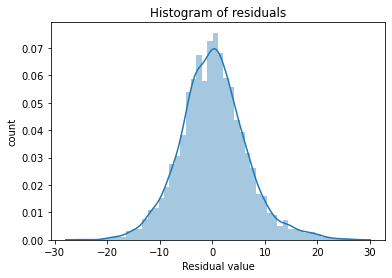

In [11]:
#plot histogram of residuals
def hist_resids(y_test, y_score):
    ## first compute vector of residuals. 
    resids = np.subtract(y_test.reshape(-1,1), y_score.reshape(-1,1))
    ## now make the residual plots
    sns.distplot(resids)
    plt.title('Histogram of residuals')
    plt.xlabel('Residual value')
    plt.ylabel('count')
    
hist_resids(y_test, y_score)

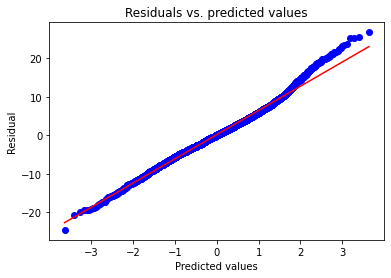

In [12]:
#draw a qq plot
def resid_qq(y_test, y_score):
    ## first compute vector of residuals. 
    resids = np.subtract(y_test.reshape(-1,1), y_score.reshape(-1,1))
    ## now make the residual plots
    ss.probplot(resids.flatten(), plot = plt)
    plt.title('Residuals vs. predicted values')
    plt.xlabel('Predicted values')
    plt.ylabel('Residual')
    
resid_qq(y_test, y_score)

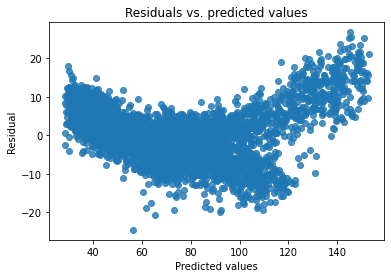

In [13]:
#draw a plot for residuals
def resid_plot(y_test, y_score):
    ## first compute vector of residuals. 
    resids = np.subtract(y_test.reshape(-1,1), y_score.reshape(-1,1))
    ## now make the residual plots
    sns.regplot(y_score, resids, fit_reg=False)
    plt.title('Residuals vs. predicted values')
    plt.xlabel('Predicted values')
    plt.ylabel('Residual')

resid_plot(y_test, y_score)

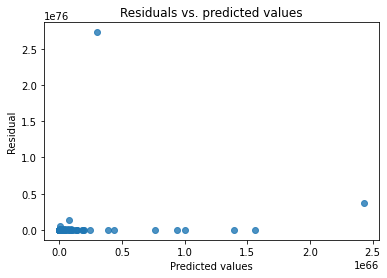

In [14]:
y_score_untransform = np.exp(y_score)
y_test_untransform = np.exp(y_test)
resid_plot(y_test_untransform, y_score_untransform)

In [15]:
ads_test = pd.read_csv(r"C:\Users\IFB19-039\Desktop\mlp\AW_test.csv")
ads_test.head()

,CustomerID,Title,FirstName,MiddleName,LastName,Suffix,AddressLine1,AddressLine2,City,StateProvinceName,...,BirthDate,Education,Occupation,Gender,MaritalStatus,HomeOwnerFlag,NumberCarsOwned,NumberChildrenAtHome,TotalChildren,YearlyIncome
0,18988,NaN,Courtney,A,Baker,NaN,8727 Buena Vista Ave.,NaN,Fremont,California,...,1/5/1945,Bachelors,Management,F,S,0,2,0,5,86931
1,29135,NaN,Adam,C,Allen,NaN,3491 Cook Street,NaN,Haney,British Columbia,...,10/4/1964,Bachelors,Skilled Manual,M,M,1,2,2,4,100125
2,12156,NaN,Bonnie,NaN,Raji,NaN,359 Pleasant Hill Rd,NaN,Burbank,California,...,1/12/1934,Graduate Degree,Management,F,M,1,2,0,4,103985
3,13749,NaN,Julio,C,Alonso,NaN,8945 Euclid Ave.,NaN,Burlingame,California,...,9/22/1958,Graduate Degree,Skilled Manual,M,M,1,0,0,4,127161
4,27780,NaN,Christy,A,Andersen,NaN,"42, boulevard Tremblay",NaN,Dunkerque,Nord,...,3/19/1965,High School,Manual,F,M,1,1,2,2,21876


In [16]:
# Calculate age of customer based on birthdate
def calculate_age(end):
    r = relativedelta(pd.to_datetime('now'), pd.to_datetime(end)) 
    return '{}'.format(r.years)


ads_test['Age'] = ads_test['BirthDate'].apply(calculate_age)

# Convert age to integer
ads_test['Age'] = ads_test['Age'].astype('int64')

In [17]:
ads_totest = ads_test[['CountryRegionName','Education','Occupation','Gender',
                      'MaritalStatus','HomeOwnerFlag','NumberCarsOwned',
                      'NumberChildrenAtHome','TotalChildren','YearlyIncome',
                      'Age']]

In [18]:
# Encode categorical data
def encode_string(cat_features):
    
    ## First encode the strings to numeric categories
    enc = preprocessing.LabelEncoder()
    enc.fit(cat_features)
    enc_cat_features = enc.transform(cat_features)
    
    ## Now, apply one hot encoding
    ohe = preprocessing.OneHotEncoder()
    encoded = ohe.fit(enc_cat_features.reshape(-1,1))
    return encoded.transform(enc_cat_features.reshape(-1,1)).toarray()

categorical_columns = ['Education','Occupation',
                       'Gender','MaritalStatus','HomeOwnerFlag']

Features = encode_string(ads_totest['CountryRegionName'])

for col in categorical_columns:
    temp = encode_string(ads_totest[col])
    Features = np.concatenate([Features, temp], axis = 1)
    
print(Features.shape)

(500, 22)


In [19]:
# Add numerical feature
Features = np.concatenate([Features, np.array(ads_totest[['NumberCarsOwned',
                                                        'NumberChildrenAtHome',
                                                        'TotalChildren',
                                                        'YearlyIncome','Age']])], axis = 1)

print(Features.shape)

(500, 27)


In [20]:
X_test = Features
X_test[:,23:] = scaler.transform(X_test[:,23:])

In [21]:
scores = lin_mod.predict(X_test)
print(scores)

[ 42.734375   107.12109375  49.0703125   88.85644531  60.58984375
  43.09179688  96.02246094 127.81152344 102.875       56.67578125
  59.19726562  50.69726562  72.95117188  46.6171875   37.859375
  51.61523438  86.08105469  73.44042969 111.74023438  59.2265625
  68.73828125  76.15234375 149.83886719  85.43945312  55.18945312
  75.2578125   87.203125   116.97460938  77.71484375  62.31640625
  69.54492188  80.76953125  39.796875    71.77734375 106.0703125
 104.38085938 149.0078125   92.88964844  59.41308594  87.69726562
  47.10742188  80.7265625   82.859375    48.765625    58.54296875
  76.18359375  61.6328125   87.7578125  116.90234375  80.359375
  81.734375    95.79882812  81.59375     64.93945312  47.0625
  76.3203125   57.68554688  75.5625      64.69726562  70.078125
  46.1875      65.79296875  90.77148438  83.16015625  43.8984375
  81.53710938  82.6953125  133.1796875   66.39453125 106.77148438
  85.83398438  68.765625    93.375       44.34179688  65.7890625
  82.5859375  115.445312

In [22]:
result_regression = pd.DataFrame(scores, index = ads_test['CustomerID'],columns=['AveMonthSpend'])

result_regression
result_regression.to_csv('dalton_result_regression_works.csv')